In [4]:
import pandas as pd 
import numpy as np 
import pandas as pd
import requests
import json
import time
import datetime as dt
import yfinance as yf
import pandas_datareader as pdr
import matplotlib.pyplot as plt

from functions.datareader import YFinanceReader

In [2]:
# ticker_list = [v + market_suffix for s in stock_sectors.values() for v in s]
# ticker_list = ['GC=F']
# yfinance_meta = yf.Tickers(ticker_list)
# is_loaded = False

gold_price_raw = yf.download('GC=F', dt.date(2000, 1, 1), dt.date(2023, 8, 29), auto_adjust=True)
gold_price_raw.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2023-08-22,1894.599976,1896.800049,1892.800049,1896.400024,46
2023-08-23,1909.599976,1918.500000,1909.599976,1918.500000,547
2023-08-24,1920.000000,1920.800049,1918.199951,1918.199951,337
2023-08-25,1919.800049,1919.800049,1911.099976,1911.099976,195
2023-08-28,1915.500000,1921.500000,1915.500000,1917.900024,99


In [55]:
# pull data from FRED
fred_keys = {
    "DFF": "fed_funds_rate",
    "IRLTLT01USM156N": "us_10y",
    "USALOLITONOSTSAM": "us_lei",
    "USACPIALLMINMEI": "us_cpi",
    "USACPICORMINMEI": "us_core_cpi",
    "CSCICP03USM665S": "consumer_opinion_surveys",
    "TOTDTEUSQ163N": "us_de_ratio",
    "DDDI06USA156NWDB": "fed_asset_to_gdp",
    "DDDM03USA156NWDB": "domestic_private_debt",
    "TRESEGUSM052N": "total_reserve_exclude_gold"
}

In [60]:
def read_fred(symbol:str, name:str = None):
    raw = pdr.get_data_fred(symbol, start='2000-01-01', end='2023-08-31')
    if name:
        raw.columns = [name]
    return raw

In [93]:
fred_data = [read_fred(k, v) for k, v in fred_keys.items()]
fred_df = pd.concat(fred_data, axis=1)
fred_df.index = pd.to_datetime(fred_df.index)

# clean values
for c in fred_df.columns:
    fred_df[c] = fred_df[c].apply(lambda x: None if x == 'NaN' or np.isnan(x) else x)

In [95]:
# save data
# fred_df.to_parquet('./data/us/economic_data/fred_data.parquet')
fred_df = pd.read_parquet('./data/us/economic_data/fred_data.parquet')

In [96]:
# for columns that do not come in daily format, mark the announcement date, and perform forward-fill
non_daily_cols = ['us_10y', 'us_lei', 'us_cpi', 'us_core_cpi', 'consumer_opinion_surveys', 
                  'us_de_ratio', 'fed_asset_to_gdp', 'domestic_private_debt', 'total_reserve_exclude_gold']
for c in non_daily_cols:
    fred_df[f'is_{c}_existed'] = ~fred_df[c].isnull()
    fred_df[c] = fred_df[c].ffill()
fred_df.head()

,fed_funds_rate,us_10y,us_lei,us_cpi,us_core_cpi,consumer_opinion_surveys,us_de_ratio,fed_asset_to_gdp,domestic_private_debt,total_reserve_exclude_gold,is_us_10y_existed,is_us_lei_existed,is_us_cpi_existed,is_us_core_cpi_existed,is_consumer_opinion_surveys_existed,is_us_de_ratio_existed,is_fed_asset_to_gdp_existed,is_domestic_private_debt_existed,is_total_reserve_exclude_gold_existed
DATE,,,,,,,,,,,,,,,,,,,
2000-01-01,3.99,6.66,101.222012,71.21852,73.809116,102.827566,NaN,4.991082,94.6063,5.884971e+10,True,True,True,True,True,False,True,True,True
2000-01-02,3.99,6.66,101.222012,71.21852,73.809116,102.827566,NaN,4.991082,94.6063,5.884971e+10,False,False,False,False,False,False,False,False,False
2000-01-03,5.43,6.66,101.222012,71.21852,73.809116,102.827566,NaN,4.991082,94.6063,5.884971e+10,False,False,False,False,False,False,False,False,False
2000-01-04,5.38,6.66,101.222012,71.21852,73.809116,102.827566,NaN,4.991082,94.6063,5.884971e+10,False,False,False,False,False,False,False,False,False
2000-01-05,5.41,6.66,101.222012,71.21852,73.809116,102.827566,NaN,4.991082,94.6063,5.884971e+10,False,False,False,False,False,False,False,False,False


<h1 style="color:turquoise">Pull data from Alphavantage</h1>
Reference: <a href="https://www.alphavantage.co/documentation/#intelligence">Alphavantage API Docs</a>

In [3]:
# Alphavantage
with open('./keys/creds.json') as f:
    keys = json.load(f)
    key = keys['AlphaVantage']

In [18]:
url = 'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=monthly&maturity=10year&apikey=demo'
base_url = 'https://www.alphavantage.co/query'
params = {
    'apikey': key,
    'function': 'TREASURY_YIELD',
    'interval': 'daily',
    'maturity': '30year',
    'datatype': 'json'
}
res = requests.get(base_url, params=params)

In [21]:
# res.json()['data']

In [26]:
# US Treasury Yield (for loop for multiple maturity intervals)
bond_yield_list = []
base_url = 'https://www.alphavantage.co/query'
params = {
    'apikey': key,
    'function': 'TREASURY_YIELD',
    'interval': 'daily',
    'datatype': 'json'
}
for maturity in ['3month', '2year', '5year', '7year', '10year', '30year']:
    params['maturity'] = maturity
    try:
        res = requests.get(base_url, params=params)
        bond_yield_df = pd.DataFrame(res.json()['data'])
        bond_yield_df['value'] = bond_yield_df['value'].apply(lambda x: None if x == '.' else float(x))
        bond_yield_df = bond_yield_df.rename(columns={'value': f'us_{maturity}'}) \
                .set_index('date').sort_index()
        bond_yield_list.append(bond_yield_df)
    except Exception as e:
        print(f'Maturity {maturity} is failed, the error message is: {e}')
    time.sleep(20)

In [44]:
bond_yield_df = pd.concat(bond_yield_list, axis=1).sort_index()
bond_yield_df.index = pd.to_datetime(bond_yield_df.index)
bond_yield_df.head(3)

,us_3month,us_2year,us_5year,us_7year,us_10year,us_30year
date,,,,,,
1962-01-02,NaN,NaN,3.88,NaN,4.06,NaN
1962-01-03,NaN,NaN,3.87,NaN,4.03,NaN
1962-01-04,NaN,NaN,3.86,NaN,3.99,NaN


Text(0.5, 1.0, 'US Bond Yield - 10 Year minus 2 Year')

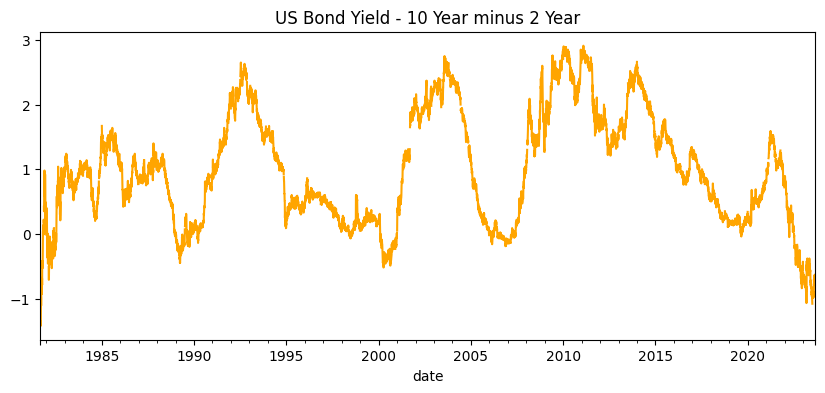

In [47]:
us_2y_10y = bond_yield_df['us_10year'] - bond_yield_df['us_2year']
us_2y_10y = us_2y_10y[us_2y_10y.index >= dt.datetime(1981, 9, 1)]
us_2y_10y.plot(color='orange', figsize=(10, 4))
plt.title('US Bond Yield - 10 Year minus 2 Year')

In [54]:
# save data
base_export_path = './data/us/bond_yield'
years = bond_yield_df.index.year.unique()
for y in years:
    year_df = bond_yield_df[bond_yield_df.index.year == y]
    year_df.to_parquet(f'{base_export_path}/{y}.parquet')